In [115]:
!pip install GetOldTweets3

In [116]:
from pandas import DataFrame, read_csv
import pandas as pd 
twitter_url_reps = r'reps.csv'
pd.set_option('mode.chained_assignment', None)
acc_df = pd.read_csv(twitter_url_reps)
df2 = acc_df[['name', 'twitter', 'party']]
df2.head()

,name,twitter,party
0,Sherrod Brown,SenSherrodBrown,Democrat
1,Maria Cantwell,SenatorCantwell,Democrat
2,Benjamin L. Cardin,SenatorCardin,Democrat
3,Thomas R. Carper,SenatorCarper,Democrat
4,"Robert P. Casey, Jr.",SenBobCasey,Democrat


In [117]:
import pandas as pd
df = pd.read_csv("./tweets/tweets.csv")

In [118]:
df.head()

,Unnamed: 0,name,twitter,party,tweet,tweet_published
0,0,Sherrod Brown,SenSherrodBrown,Democrat,"This year, #WorkersMemorialDay is particularly...",2020-04-28
1,1,Sherrod Brown,SenSherrodBrown,Democrat,"Without the #ACA, health insurers could discri...",2020-03-23
2,2,Sherrod Brown,SenSherrodBrown,Democrat,Just voted to send more than 15 million in eme...,2020-03-05
3,3,Sherrod Brown,SenSherrodBrown,Democrat,Mitch McConnell has wasted four days in the mi...,2020-03-17
4,4,Sherrod Brown,SenSherrodBrown,Democrat,"TUNE IN: At 12:25 PM, I'm going Live with my f...",2020-05-21


In [119]:
dem_tweets = [x for i,x in df.iterrows() if x["party"] == "Democrat"]
rep_tweets = [x for i,x in df.iterrows() if x["party"] == "Republican"]
print(len(rep_tweets))
print(len(dem_tweets))

21234
42820


In [120]:
!pip install num2words

In [121]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
import math
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quynh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quynh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quynh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [122]:
df = df[df.party != 'Independent']
democrat_tweets_df = df[df.party == 'Democrat']
republican_tweets_df = df[df.party == 'Republican']
democrat_tweets_df = democrat_tweets_df.sample(frac = 0.5)
# df = democrat_tweets_df + republican_tweets_df

In [123]:
republican_tweets_df.drop(['Unnamed: 0'],  axis=1, inplace=True)
democrat_tweets_df.drop(['Unnamed: 0'],  axis=1, inplace=True)

In [124]:
frames = [democrat_tweets_df, republican_tweets_df]
df = pd.concat(frames)

Counter({'Democrat': 21410, 'Republican': 21234})


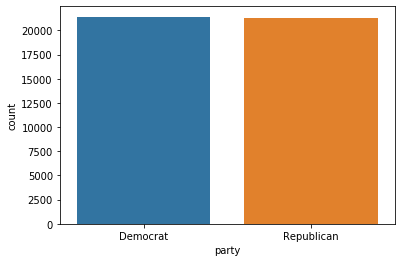

In [125]:
import seaborn as sns
def plot_count(data):
    y = Counter(data)
    print(y)
    sns.countplot(data)
plot_count(df['party'])

# Split the dataset 

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report,accuracy_score

In [127]:
X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'], df['party'], test_size = 0.25, random_state = 42, stratify=df['party'])

# Doing some work with feature selection

In [128]:
class_label={'Democrat':0,'Republican':1}
reverse_class_label={0:'Democrat',1:'Republican'} 
def table_creation(X_train,Y_train):
  table={}             # will contain the article count of a term in a class
  term_count_in_class={}         # will contain the term count in a class
  class_doc_count=np.array([0,0])  # number of articles in a class
  class_word_count=np.array([0,0]) # number of words in a class
  class_count=np.array([0,0])

  for article,label in zip(X_train,Y_train):
    #print(article)
    class_doc_count[class_label[label]]+=1
    class_word_count[class_label[label]]+=len(article)
    unique_tokens={-1}
    for term in article.split():
      #print(term)
      #term count in of each term in each class
      if term not in term_count_in_class:
        term_count_in_class[term]=class_count.copy()
      term_count_in_class[term][class_label[label]]+=1
      unique_tokens.add(term)
    
    #print("unique tokens in article are",unique_tokens)
    unique_tokens.remove(-1) 

    for term in unique_tokens:
      if term not in table:
        table[term]=class_count.copy()
      table[term][class_label[label]]+=1
  
  return table, class_word_count, class_doc_count, term_count_in_class
table, class_word_count, class_doc_count, term_count_in_class=table_creation(X_train,Y_train)

In [129]:
table, class_word_count, class_doc_count, term_count_in_class=create_info(X_train,Y_train)

In [130]:
#to calculate mutual information for each term in each class
def cal_mutual_info(table,class_word_count,class_doc_count):
  N=0
  for i in class_doc_count:
    N+=i
  print("total number of articles are",N)
  mi_table=[[],[],[],[]]  # five list to contain the mutual information for each class 
  for term in table:
      #print("calculating mi for ",term," ",table[term])
      for class_ in range(0,2):
          #print("for class ",class_)
          n11=table[term][class_]         # term is present in class
          n10=np.sum(table[term])-n11        # term is present but not in the class
          n01=class_doc_count[class_]-n11   # number of docs in class not having term 
          n00=N-(n01+n10+n11)                  # number of docs neither term nor class
          #print("n11,n10,n01,n00 ",n11,n10,n01,n00)
          
          if n11==0:
              t1=0
          else:
              t1=(n11/N) * ((np.log(N)+np.log(n11)) - (np.log(n11+n01) + np.log(n11+n10)))
          if n01==0:
              t2=0
          else:
              t2=(n01/N) * ((np.log(N)+np.log(n01)) - (np.log(n01+n00) + np.log(n01+n11)))
          if n10==0:
              t3=0
          else:
              t3=(n10/N) * ((np.log(N)+np.log(n10)) - (np.log(n10+n11) + np.log(n10+n00)))
          if n00==0:
              t4=0
          else:
              t4=(n00/N) * ((np.log(N)+np.log(n00)) - (np.log(n00+n01) + np.log(n00+n10)))
          m=t1+t2+t3+t4
          mi_table[class_].append(m)
  return mi_table
mi_table=cal_mutual_info(table,class_word_count, class_doc_count)



#creating word map, each word is assigned a uniuqe id like we did for each document
def create_word_map(list_of_words):
    word_forward_map={}
    word_reverse_map={}
    count=0
    for word in list_of_words:
        word_forward_map[word] = count
        count = count + 1
    word_reverse_map = {v: k for k, v in word_forward_map.items()}
    return word_forward_map,word_reverse_map
word_forward_map,word_reverse_map=create_word_map(table.keys())



#this method will select feaures for each class and returns new vocabulary
def feature_selection(mi_table,k,word_forward_map,word_reverse_map):
    top_k_words=[]
    for class_id in range(0,2):
        temp = np.argsort(np.array(mi_table[class_id]))
        temp = temp[::-1]
        top_k_words.append(temp[:k].copy())
    
    new_vocab={-1}
    count=0
    for list_of_words in top_k_words:
        #print(list_of_words)
        #print("for class ",count," top ",k," words are")
        for wordid in list_of_words:
            #print(word_reverse_map[wordid])
            new_vocab.add(word_reverse_map[wordid])
        count=count+1
        
    new_vocab.remove(-1)
    #print(new_vocab)
    return top_k_words,new_vocab

top_k_words,new_vocab=feature_selection(mi_table,200,word_forward_map,word_reverse_map)







#to calculate term and class probability 
def calculate_probability(new_vocab,term_count_in_class,class_word_count,class_doc_count):
    term_probability={}
    beta=len(new_vocab)
    for word in new_vocab:
      #print(word)
      term_probability[word]=[]
      for class_id in range(0,2):
        tot=class_word_count[class_id]
        #print("word count in class",tot)
        tc=term_count_in_class[word][class_id]
        p=(tc+1)/(tot+beta)  #add one smoothening
        term_probability[word].append(p)    
    class_probability=[]
    N=np.sum(class_doc_count)
    #print(N)
    for doc_count in class_doc_count:
        class_probability.append(doc_count/N)
    return class_probability,term_probability
class_probability,term_probability=calculate_probability(new_vocab,term_count_in_class,class_word_count,class_doc_count)

total number of articles are 31983.0


#### Doing Naive Bayes

In [131]:
def naive_bayes(new_vocab,term_probability,class_probability,X_test):
    y_predicted=[]
    for article in X_test:
        max_score=-math.inf
        score=0
        result_class=-1                          #initially document belonging to none class
        for class_id in range(0,2):
            score=np.log(class_probability[class_id])
            for word in article.split():
                if word in new_vocab:
                    score=score+np.log(term_probability[word][class_id])
            #print("docid ",docid," class ",class_id," score ",score)
            if score>max_score:
                max_score=score
                result_class=class_id
        #result[docid]=result_class
        y_predicted.append(reverse_class_label[result_class])       
    return y_predicted          

y_predicted=naive_bayes(new_vocab,term_probability,class_probability,X_test)
def performance(y_actual,y_predicted):
    results = confusion_matrix(y_actual, y_predicted)   
    print ('Confusion Matrix :')
    print(results) 
    print ('Accuracy Score :',accuracy_score(y_actual, y_predicted) )
    print ('Report : ')
    print (classification_report(y_actual, y_predicted) )
    return accuracy_score(y_actual, y_predicted)

performance(Y_test,y_predicted)

Confusion Matrix :
[[3584 1769]
 [3267 2041]]
Accuracy Score : 0.5276240502767096
Report : 
              precision    recall  f1-score   support

    Democrat       0.52      0.67      0.59      5353
  Republican       0.54      0.38      0.45      5308

    accuracy                           0.53     10661
   macro avg       0.53      0.53      0.52     10661
weighted avg       0.53      0.53      0.52     10661



0.5276240502767096

### Doing Naive Bayes without Feature Selection

In [132]:
######NaiiveBayes without Feature Selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

Count=CountVectorizer()
X_train_count=Count.fit_transform(X_train)
X_test_count=Count.transform(X_test)

Tf_idf=TfidfTransformer()
X_train_tfidf=Tf_idf.fit_transform(X_train_count)
X_test_tfidf=Tf_idf.transform(X_test_count)
Classifier = MultinomialNB().fit(X_train_tfidf, Y_train)
predicted = Classifier.predict(X_test_tfidf)


print(f1_score(Y_test, predicted,average='weighted'))
print(classification_report(Y_test,predicted))
print(accuracy_score(Y_test,predicted))

0.8235731846905489
              precision    recall  f1-score   support

    Democrat       0.81      0.84      0.83      5353
  Republican       0.84      0.80      0.82      5308

    accuracy                           0.82     10661
   macro avg       0.82      0.82      0.82     10661
weighted avg       0.82      0.82      0.82     10661

0.8236563174186287


#### Doing SVM with Feature Selection

In [ ]:
# SVM without feature Selection using different approaches:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
# SVM with feature selection
def produce_count_vector(X_data,vocab,term_count_in_class):
    data_count=[]
    for index in X_data:
        count_vector=[]
        values=index.split(' ')
        for word in vocab:
            if word in values:
                count_vector.append(values.count(word))
            else:
                count_vector.append(0)
        data_count.append(count_vector)
    return data_count

X_train_count=produce_count_vector(X_train,new_vocab,term_count_in_class)
X_test_count=produce_count_vector(X_test,new_vocab,term_count_in_class)


from sklearn.feature_extraction.text import TfidfTransformer
vector=TfidfTransformer()
X_train_vector=vector.fit_transform(X_train_count)
X_test_vector=vector.transform(X_test_count)
classifier=SVC(verbose=True).fit(X_train_vector,Y_train)
predicted=classifier.predict(X_test_vector)
print(f1_score(Y_test,predicted,average='weighted'))
print(classification_report(Y_test,predicted))
print(accuracy_score(Y_test,predicted))

### SVM Feature Selection

In [ ]:
# SVM with tf-idf
#1. tf-idf using n grams
#a) unigram
print("For unigrams--------------------")
vector=TfidfVectorizer(analyzer='word',ngram_range=(1,1))
X_train_vector=vector.fit_transform(X_train)
X_test_vector=vector.transform(X_test)
classifier=SVC(verbose=True).fit(X_train_vector,Y_train)
predicted=classifier.predict(X_test_vector)
print(f1_score(Y_test,predicted,average='weighted'))
print(classification_report(Y_test,predicted))
print(accuracy_score(Y_test,predicted))


print("For Bigrams----------------------")
#b) bigram
vector=TfidfVectorizer(analyzer='word',ngram_range=(2,2))
X_train_vector=vector.fit_transform(X_train)
X_test_vector=vector.transform(X_test)
classifier=SVC(verbose=True).fit(X_train_vector,Y_train)
predicted=classifier.predict(X_test_vector)
print(f1_score(Y_test,predicted,average='weighted'))
print(classification_report(Y_test,predicted))
print(accuracy_score(Y_test,predicted))

For unigrams--------------------
[LibSVM]